<a href="https://colab.research.google.com/github/marc1971/Assignement-Module4-CAS-NLP/blob/main/Image_Classification_pretrainedViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook to train a pretrained model (ViT) for image classification**

## A: Problem and Dataset Description

**Preliminary remarks:**

The task in this module was actually to solve an NLP task using transformers and to compare it with the results of a classical neural network. I have taken the liberty of deviating slightly from the actual task. I will extend the experimentation with neural networks to the classification of images. There are three reasons for this.
1. as an assignment for Module 2, I have already trained a transformer model with great effort for a Q&A task with my own text corpus, compiled the results and presented them in the course.
2. my interest in this CAS is to try out the broadest possible application of classical NNs and transformers.
3. have a concrete application on which I can try out the classification of images.

**Problem:**

As an orienteer, I am involved in the production of specific maps for this sport. In Switzerland, there are basically 4 different types of terrain in which orienteering is practised. Alpine terrain, pre-alpine terrain, central plateau (Mittelland) and Jura. The different types of terrain are reflected in the maps. Alpine terrain is mostly without forest, rather steep and stony, the Central Plateau consists of very heavily managed forests with clear forest structures and many forest paths, etc.
The task is now to train a NN to be able to assign the map section to a terrain type based on a small map section (224x224 pixels x 3 colour layers) (classification task).  

**Data-Examples:**

**Alpine:**

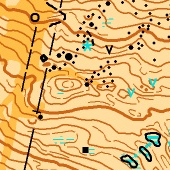

**Pre-Alpine:**

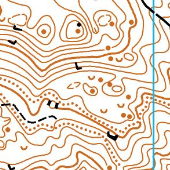

**Central Plateau:**

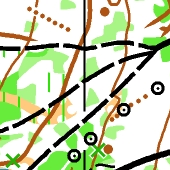

**Jura:**

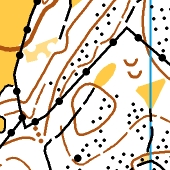

**Data Base**

The data base consists of 3987 Images in the 4 terrain categories, but unfortunately very unevenly distributed:

Alpine:           339 Imgs

Pre-Alpine:      1276 Imgs

Cantral Plateau: 1355 Imgs

Jura:            1017 Imgs

The data set is split-up in 80% training- and 20% test-data.

**Data prepearing**

To prepare the data, maps were cut into images of 224x224 pixels. All map images have 3 color channals. Since some map images had 3 more channals for transarency information. All the maps hat to be reduced to the same dimention (3x224x224).

## B: Approaches taken - Contrast transformer based approaches with other NN or traditional approaches

The chosen approach here is to use a pre-trained vision transformer (ViT) to classify the images. The results are compared with the calssification with a classicle Convolution Neural Net (CNN).

## 1. Classification wich a pretraines ViT Model

I start by desribing the work for finetuning a pretrained ViT model. I spent the most of the time of this exercise by studiing and adabting a template code for training a pretrained ViT model and for doing the data-preperation.

### Datapreperation

The data preparation included the following steps:

1. Finding as much as O-Maps as possible

2. Catorizing the O-Maps in the four categories (see above)

3. Cutting the O-Maps in image snipplets in the used format (3x224x224 pixels)

4. Assigning the Images to training- and test-folder respectively and there in the corresponding caregory-folders (alpine, jura, mittelland, prealpine)

When working with the Transformer model, I did not use the "*data augmentation*" technique. I used this when using the classic CNN model (see notebook "Image_Classification_CNN").

### Loading a pretrained model

The next step ist to load the pretrained model. After loaded the model, the parameters of the model are frozen (I dont want to train them!). Then I add a linear Layer with 768 input neurons and 4 (numer of categories) output neurons.

In [ ]:
#Import needed packages
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

#Import own functions (vgl. GitHub Reporitory)
import helper_functions
import engine

In [ ]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting divice (CUDA if it is available)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['alpin','jura', 'mittelland', 'voralpin']

# 5. Set random seeds
from helper_functions import set_seeds
set_seeds()

#6. Add a Linear Layer to be trained
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 48.3MB/s]


In [ ]:
!pip install torchinfo

Here I have visualised the architecture of the model.

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(64, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]  [64, 4]            768                Partial
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]  [64, 768, 14, 14]  (590,592)          False
├─Encoder (encoder)                                          [64, 197, 768]     [64, 197, 768]     151,296            False
│    └─Dropout (dropout)                                     [64, 197, 768]     [64, 197, 768]     --                 --
│    └─Sequential (layers)                                   [64, 197, 768]     [64, 197, 768]     --                 False
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]     [64, 197, 768]     (7,087,872)        False
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]     [64, 197, 768]     (7,087,872)        False
│    

Notice: only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen). This gives us 85,801,732 parameters, of which only 3076 are trainable.

### Loading the data for training/testing

Next, we load and prepare the data for training and testing.

In [ ]:
# Setup directory paths to train and test images
train_dir = '/content/drive/My Drive/ColabNotebooks/Data/images_transformer/train'
test_dir = '/content/drive/My Drive/ColabNotebooks/Data/images_transformer/test'

It's important to ensure the own custom data is transformed/formatted in the same way the data the original model was trained on! Therefore we prepare a automatic transforms:

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Now transforms is ready, we can turn the images into DataLoaders using the create_dataloaders()

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
    ):

  # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
    class_names = train_data.classes

  # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=64)


### Training the model

Now we are ready for training the model! Therefore I use a helperfunction "*train*" from the package "*engine*" (see GitHub repository).

In [ ]:
from engine import train

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8101 | train_acc: 0.6734 | test_loss: 0.5633 | test_acc: 0.7969
Epoch: 2 | train_loss: 0.4947 | train_acc: 0.8319 | test_loss: 0.4596 | test_acc: 0.8474
Epoch: 3 | train_loss: 0.4118 | train_acc: 0.8645 | test_loss: 0.4097 | test_acc: 0.8558
Epoch: 4 | train_loss: 0.3615 | train_acc: 0.8856 | test_loss: 0.3764 | test_acc: 0.8770
Epoch: 5 | train_loss: 0.3244 | train_acc: 0.8990 | test_loss: 0.3567 | test_acc: 0.8702
Epoch: 6 | train_loss: 0.3009 | train_acc: 0.9059 | test_loss: 0.3373 | test_acc: 0.8786
Epoch: 7 | train_loss: 0.2795 | train_acc: 0.9158 | test_loss: 0.3186 | test_acc: 0.8942
Epoch: 8 | train_loss: 0.2617 | train_acc: 0.9206 | test_loss: 0.3106 | test_acc: 0.8978
Epoch: 9 | train_loss: 0.2466 | train_acc: 0.9286 | test_loss: 0.3018 | test_acc: 0.9014
Epoch: 10 | train_loss: 0.2346 | train_acc: 0.9281 | test_loss: 0.2942 | test_acc: 0.8998
Epoch: 11 | train_loss: 0.2236 | train_acc: 0.9341 | test_loss: 0.2862 | test_acc: 0.8966
Epoch: 12 | train_l

# C: Results and Evaluation

### Visualizing and analyzing the training-process


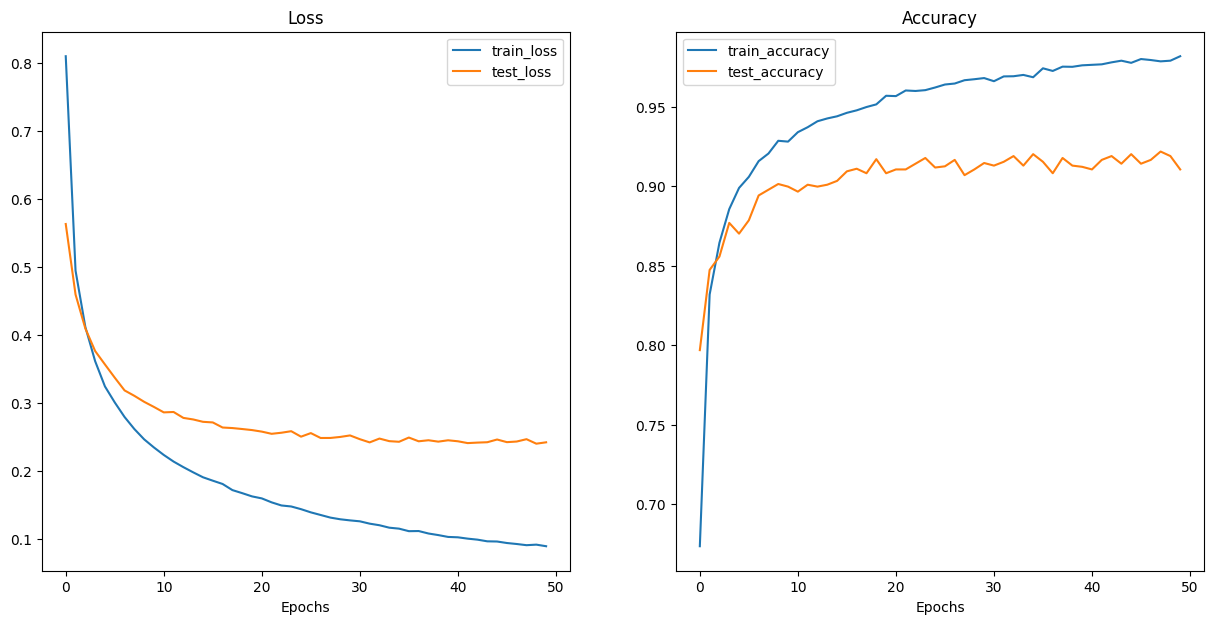

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Making predictions and applying the model to unseen data

We test now the model by applying it to a unseen example and plot *the image*, *the predicted category* and *the probaility* of the classification.

Therefore we have to prepare the new sample image the same way as the train and test data (same dimantions and transformation to a Pytoch Tensor), then feed it into the model and make a back-transformation of the results (from PyTorch Tensor to Numpy-Array etc.)

All this steps is done by another helper function called *pred_and_plot_image* in the package *helper_functions*.

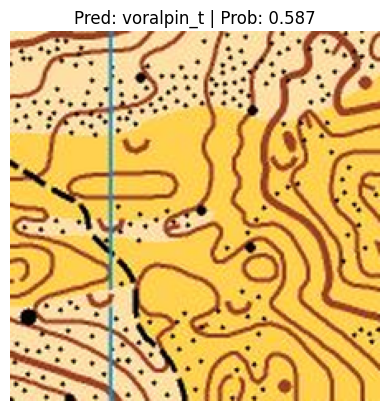

In [ ]:
import requests

# Import function to make predictions on images and plot them
from helper_functions import pred_and_plot_image
# Setup custom image path
#Test-Maps:
#AR01_0-1.png -> alpin (Arosa)
#BR01.png -> jura (Brunnersberg)
#CB01_0-0.png -> jura (Chanet de Bevais)
#HB01_0-0.png -> mittelland (Harben)
#LH01_0-1.png -> mittelland (Längholz)
#MU02_0-1.png -> mittelland (Minuberghöchi)

#Example
custom_image_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/AR01_0-1.png"


# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

I will now apply this to all 148 examples (unseen images). In the same step I create a list with all predictions and corresponding probabilities. Therefore I adapted the helper function "pred_and_plot_image2" slightly (see point 7a).

In [ ]:
from typing import List
import torchvision

def pred_and_plot_image2(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
	):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.png",
                            class_names=["class_1", "class_2", "class_3", "class_4"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 7a read out pred labels an probs
    id_lst.append(img[0:2])

    pred_tensor = target_image_pred_label.cuda()
    numpy_array_pred = pred_tensor.cpu().numpy()
    pred = numpy_array_pred[0]
    prd_lst.append(pred)

    prob_tensor = target_image_pred_probs.cuda()
    numpy_array_prob = prob_tensor.cpu().numpy()
    prob = numpy_array_prob[0]
    prob_lst.append(prob)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

Now I aplly this function on all 148 Images.

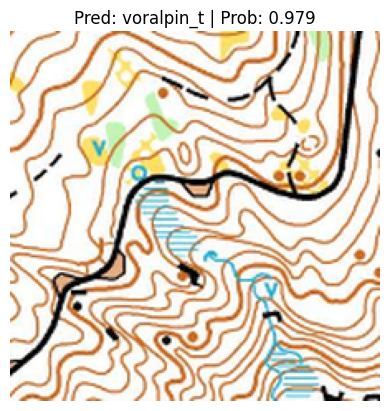

In [ ]:

# Creating a
import helper_functions

image_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/"
image_save_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/pred/"
id_lst = []
prd_lst =[]
prob_lst = []

for img in os.listdir(image_path):
  pred_and_plot_image2(model=pretrained_vit,
                    image_path=image_path+img,
                    class_names=class_names)
  plt.savefig(image_save_path+img, dpi=300, bbox_inches='tight')

I have to check, if it worked and if the produced lists have the same length.

In [ ]:
#List of predictions (0 = 'alpine', 1 = 'jura', 2 = 'cetral plateau', 3 = 'prealpine')
print(len(prd_lst))

#List of probabilities: For every pictures the probability of all four categories ar listed (not only the maximum probability)
print(len(prob_lst))

#List of the ID of the corresponding map
print(len(id_lst))

148
148
148


In [ ]:
#Example of the prediction-list
print(prd_lst)

[1, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 2, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 1, 0, 2, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 3]


Now we get the results off applying the model and write it into a Pandas DataFrame (and store it in a excel file).

In [ ]:
import pandas as pd

# list of name, degree, score


# dictionary of lists
dict = {'Karte': id_lst, 'Typ': prd_lst, 'Probability': prob_lst}

df = pd.DataFrame(dict)

# Export the DataFrame to an Excel file
df.to_excel('/content/drive/My Drive/ColabNotebooks/Data/images_transformer/Testresults.xlsx', index=False)
df


,Karte,Typ,Probability
0,BR,1,"[0.0008266087, 0.9377009, 0.0040939576, 0.0573..."
1,BR,3,"[0.0016528899, 0.0048288675, 0.0005056075, 0.9..."
2,BA,3,"[0.07690013, 0.00027059653, 0.0006655034, 0.92..."
3,BR,2,"[0.00012114858, 0.08770606, 0.91210157, 7.1294..."
4,BA,3,"[0.0009393184, 0.015074202, 0.009263007, 0.974..."
...,...,...,...
143,MU,2,"[4.4335266e-06, 0.059545435, 0.9394746, 0.0009..."
144,MU,2,"[6.3590865e-05, 0.27499336, 0.702439, 0.022504..."
145,MU,2,"[3.2510102e-06, 0.0007916039, 0.9792325, 0.019..."
146,UF,3,"[0.00024377827, 0.05238029, 0.24740438, 0.6999..."


from matplotlib import pyplot as plt
df['Typ'].plot(kind='hist', bins=20, title='Typ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Typ'].plot(kind='line', figsize=(8, 4), title='Typ')
plt.gca().spines[['top', 'right']].set_visible(False)

I did an analysis of the performance of the model by analyzing the confusion matrix and the all the different performance metrics *accuracy*, *precision*, *recall* and *the F1-score*.

First I load the list of the testresults.

In [ ]:
# import pandas lib as pd
import pandas as pd

# read by default 1st sheet of an excel file
df = pd.read_excel('/content/drive/My Drive/ColabNotebooks/Data/images_transformer/Testresults_lab2.xlsx')

print(df)

    Karte  Typ                                        Probability  \
0      AR    3  [1.8858233e-01 2.7576001e-02 5.6331537e-05 7.8...   
1      BA    3  [7.6900132e-02 2.7059653e-04 6.6550338e-04 9.2...   
2      BA    3  [9.3931839e-04 1.5074202e-02 9.2630070e-03 9.7...   
3      BA    3  [2.0889251e-02 2.4877531e-03 4.5785963e-04 9.7...   
4      BA    3      [0.01471372 0.14239402 0.01238946 0.83050287]   
..    ...  ...                                                ...   
143    MU    2  [6.3590865e-05 2.7499336e-01 7.0243901e-01 2.2...   
144    MU    2  [3.2510102e-06 7.9160387e-04 9.7923249e-01 1.9...   
145    NV    0  [9.7856528e-01 2.2769370e-03 1.2971840e-05 1.9...   
146    UF    3  [2.4377827e-04 5.2380290e-02 2.4740438e-01 6.9...   
147    UF    3       [0.01161674 0.00300131 0.0066171 0.9787649 ]   

     Ground Truth  
0               3  
1               3  
2               3  
3               3  
4               3  
..            ...  
143             2  
144        

Then I create the confusion matrix.

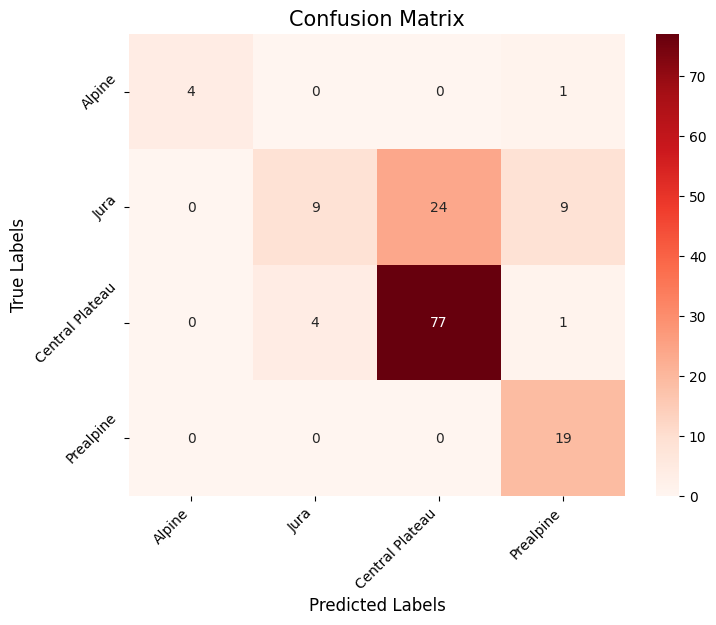

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming true_labels and predictions are defined
confusion_mtx = confusion_matrix(df['Ground Truth'], df['Typ'])

# Define your custom tick labels
tick_labels = ['Alpine', 'Jura', 'Central Plateau', 'Prealpine']  # Replace with your class names

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Reds')

# Set the labels for x-axis and y-axis
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Set the custom tick labels
ax.set_xticklabels(tick_labels, rotation=45, ha='right')  # ha is horizontal alignment
ax.set_yticklabels(tick_labels, rotation=45)

# Optionally, set a title for the plot
plt.title('Confusion Matrix', fontsize=15)

plt.show()

And finally there are the different performance metrics:

In [ ]:
A_TP = 0
A_FP = 0
A_TN = 0
A_FN = 0

VA_TP = 0
VA_FP = 0
VA_TN = 0
VA_FN = 0

M_TP = 0
M_FP = 0
M_TN = 0
M_FN = 0

J_TP = 0
J_FP = 0
J_TN = 0
J_FN = 0

for index, row in df.iterrows():
    if row.iloc[3]==0 and row.iloc[1]==0:
        A_TP +=1
    if row.iloc[3]!=0 and row.iloc[1]!=0:
        A_TN +=1
    if row.iloc[3]!=0 and row.iloc[1]==0:
        A_FP +=1
    if row.iloc[3]==0 and row.iloc[1]!=0:
        A_FN +=1

    if row.iloc[3]==1 and row.iloc[1]==1:
        J_TP +=1
    if row.iloc[3]!=1 and row.iloc[1]!=1:
        J_TN +=1
    if row.iloc[3]!=1 and row.iloc[1]==1:
        J_FP +=1
    if row.iloc[3]==1 and row.iloc[1]!=1:
        J_FN +=1


    if row.iloc[3]==2 and row.iloc[1]==2:
        M_TP +=1
    if row.iloc[3]!=2 and row.iloc[1]!=2:
        M_TN +=1
    if row.iloc[3]!=2 and row.iloc[1]==2:
        M_FP +=1
    if row.iloc[3]==2 and row.iloc[1]!=2:
        M_FN +=1

    if row.iloc[3]==3 and row.iloc[1]==3:
        VA_TP +=1
    if row.iloc[3]!=3 and row.iloc[1]!=3:
        VA_TN +=1
    if row.iloc[3]!=3 and row.iloc[1]==3:
        VA_FP +=1
    if row.iloc[3]==3 and row.iloc[1]!=3:
        VA_FN +=1

A_all = len(df[df['Ground Truth']==0])
J_all = len(df[df['Ground Truth']==1])
M_all = len(df[df['Ground Truth']==2])
VA_all = len(df[df['Ground Truth']==3])

#Accuracy: (TP+TN)/(TP+FP+TN+FN)

A_acc = (A_TP+A_TN) / (A_TP+A_FP+A_TN+A_FN)
VA_acc = (VA_TP+VA_TN) / (VA_TP+VA_FP+VA_TN+VA_FN)
M_acc = (M_TP+M_TN) / (M_TP+M_FP+M_TN+M_FN)
J_acc = (J_TP+J_TN) / (J_TP+J_FP+J_TN+J_FN)

#Precision: TP/(TP+FP)

A_prec = A_TP / (A_TP+A_FP)
VA_prec = VA_TP / (VA_TP+VA_FP)
M_prec = M_TP / (M_TP+M_FP)
J_prec = J_TP / (J_TP+J_FP)

#Recall: TP/(TP+FP)

A_rec = A_TP / (A_TP+A_FN)
VA_rec = VA_TP / (VA_TP+VA_FN)
M_rec = M_TP / (M_TP+M_FN)
J_rec = J_TP / (J_TP+J_FN)

#F1S: TP/TP+1/2*(FP+FN)

A_F1S = A_TP / (A_TP+0.5*(A_FP+A_FN))
VA_F1S = VA_TP / (VA_TP+0.5*(VA_FP+VA_FN))
M_F1S = M_TP / (M_TP+0.5*(M_FP+M_FN))
J_F1S = J_TP / (J_TP+0.5*(J_FP+J_FN))


print('Typ Alpine: \nN:', A_all,'\nAccuracy:', round(A_acc,2), '\nPrecision:', round(A_prec,2), '\nRecall:', round(A_rec,2), '\nF1 Score:', round(A_F1S,2))
print()
print('Typ Pre-Alpine: \nN:', VA_all,'\nAccuracy:', round(VA_acc,2), '\nPrecision:', round(VA_prec,2), '\nRecall:', round(VA_rec,2), '\nF1 Score:', round(VA_F1S,2))
print()
print('Typ Mittelland: \nN:', M_all,'\nAccuracy:', round(M_acc,2), '\nPrecision:', round(M_prec,2), '\nRecall:', round(M_rec,2), '\nF1 Score:', round(M_F1S,2))
print()
print('Typ Jura: \nN:', J_all, '\nAccuracy:', round(J_acc,2), '\nPrecision:', round(J_prec,2), '\nRecall:', round(J_rec,2), '\nF1 Score:', round(J_F1S,2))


Typ Alpine: 
N: 5 
Accuracy: 0.99 
Precision: 1.0 
Recall: 0.8 
F1 Score: 0.89

Typ Pre-Alpine: 
N: 19 
Accuracy: 0.93 
Precision: 0.63 
Recall: 1.0 
F1 Score: 0.78

Typ Mittelland: 
N: 82 
Accuracy: 0.8 
Precision: 0.76 
Recall: 0.94 
F1 Score: 0.84

Typ Jura: 
N: 42 
Accuracy: 0.75 
Precision: 0.69 
Recall: 0.21 
F1 Score: 0.33


#D and E: Discussion and limitation of approach

### Discussion


Despite the relatively small amount of training data and the often ambiguous classification even for experienced specialists, the model classifies surprisingly well and makes comprehensible errors. This is particularly astonishing given that a pre-trained model was used that was trained to classify objects rather than the structure of images.

**Alpine**
The maps of type "Apline" are very easy to assign. The map sections are characterised by open terrain (yellow), which is often interspersed with stones (black dots) and dense elevation curves. The model makes almost no errors here. The only risk of confusion is with the "Prealpine" category, although even the correct categorisation is not clear here.

**Jura**

The hardest category for the model to classify is the Jura. Certain sections of the map are very difficult to distinguish from those of the Central Plateau, even for experienced orienteers. Accordingly, the model also has the greatest difficulty here. Maps of the Jura type are very often confused with the Central Plateau. They are even more often incorrectly categorised as Mittelland than they are correctly categorised.

**Cantral Plane**

The map sections from the Central Plateau are also easy to classify. This is also where the most training data is available. There is a risk of confusion here, especially with the "Jura" terrain type.

**Prealpine**

The pre-alpine terrain is a mixture of alpine and Jura maps. Accordingly, the model also makes the misclassification here.

### Conclusion an suggestions for improvement and further tests

Basically, it can be stated that a model cannot be trained for classification if a person is hardly capable of doing so. With the available data, the classification of some examples is not clear even for a specialist. Despite the already good results with the current procedure, there are some suggestions for improvement:

**1. Creating a better data basis:**

We could provide much more and, above all, a more balanced distribution of training data across the categories. The data could also be of better quality.

**2. More sophisticated data preparation**

There are techniques such as "data augmentation" to improve data preparation. This could also be applied here.

**3. Choice of a more specific model**

The selected model is a general model for classifying images according to their content, whereby the classification criteria are usually objects (cat, dog). In our task, we are dealing with structures and features according to which we want to classify. There may be more suitable models specifically for this.

**4. Variation of the hyperparameters**

When training the model, only the three parameters *batch size*, *learning rate* and *number of epochs* were varied. This would have to be varied more systematically or other parameters could be changed (e.g. alternative optimizer to ADAM; SGD, SGD with gradient clipping, Momentum, Nesterov Momentum, Adagrad, Adadelta, RMSProp, Adamax, SMORMS3, etc.)

## 2. Classification with classic CNN

The whole Notebook for the training of a classic CNN with the exacly same task as here can be see in te File Image_Classification_CNN.jpnb on GitHub. There a model was built as in the scheme below.

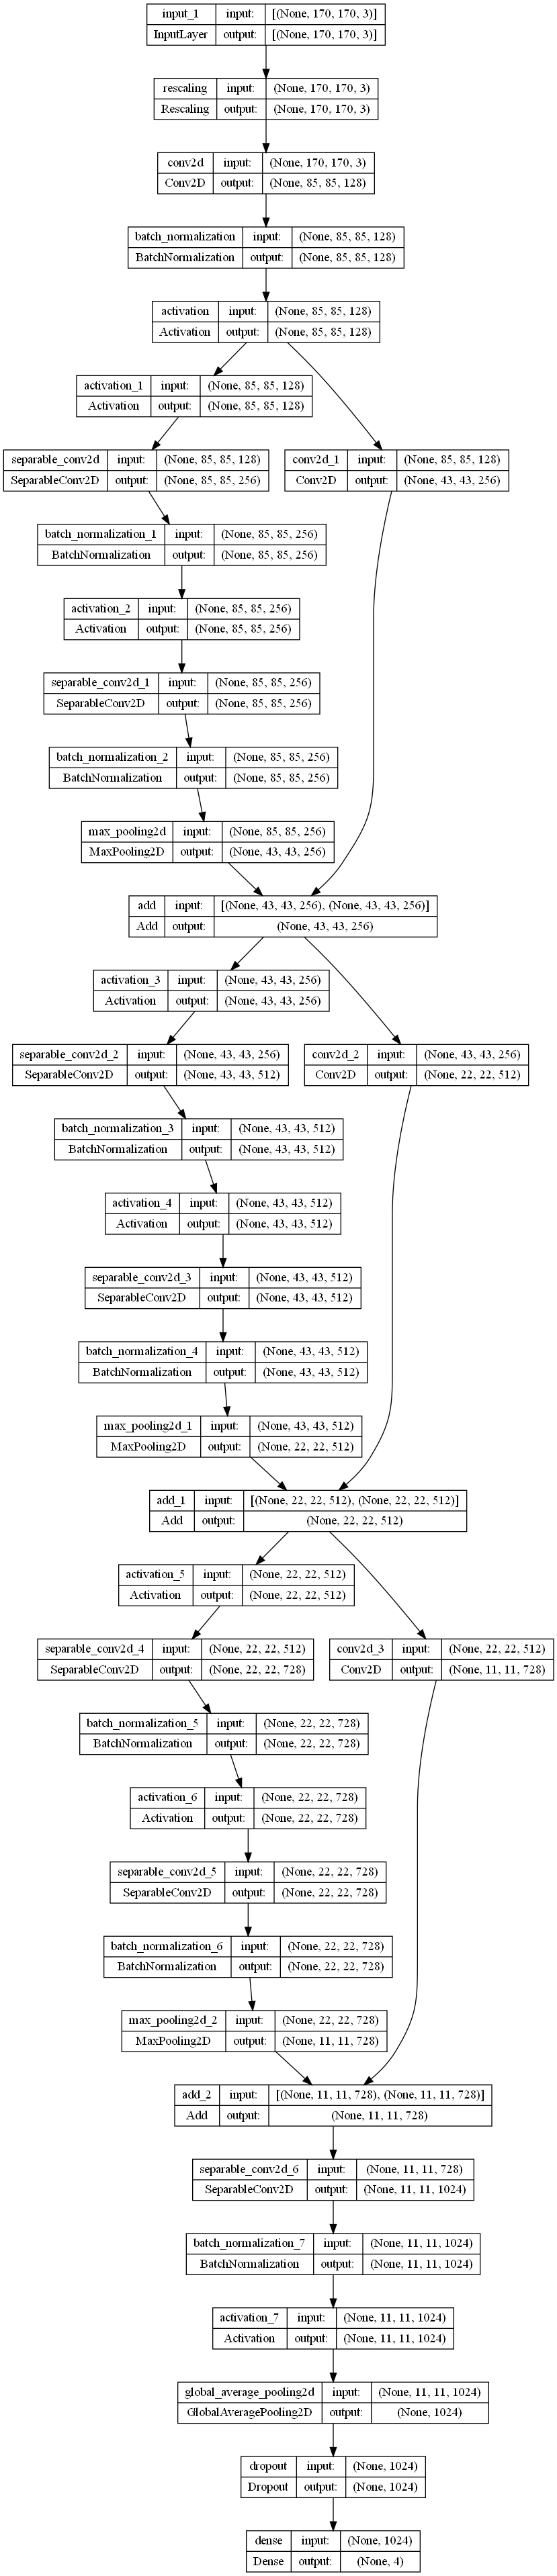

The data praparation was similar to the exercise here with two exceptions: The image dimension was 3x170x170 and a data-augemtation process was applyed in addition (see Notebook *Image_Classification_CNN.ypnb*).

### Training

The behaviour when training the CNN (left) is significantly more unstable than when training the Transformer model (right). This probably has to do with the fact that the training is done "from scratch".



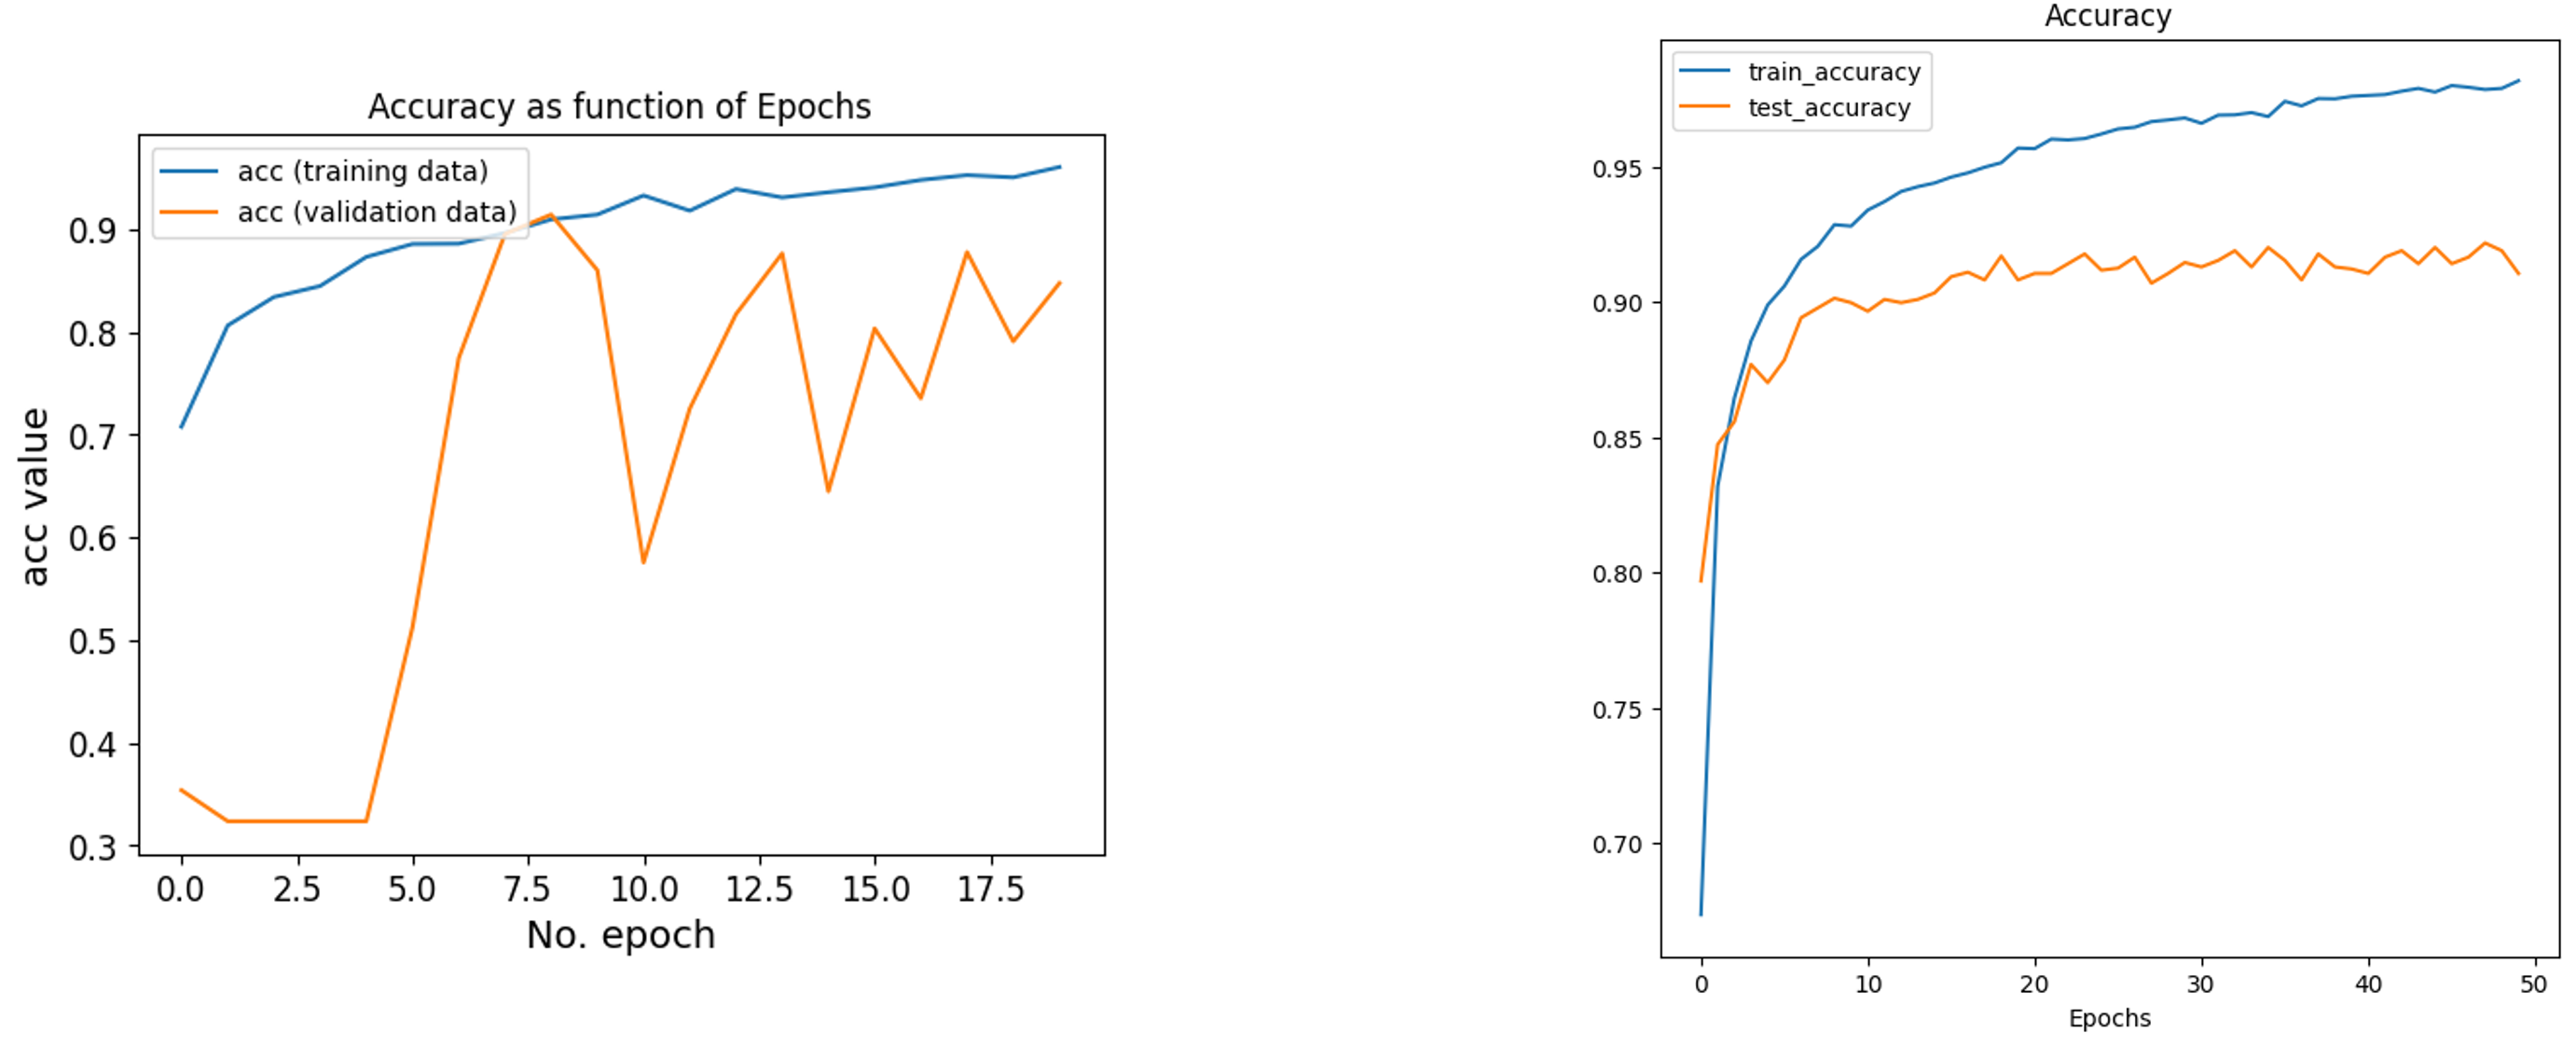